In [1]:
import warnings
import os
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, reading CSV file
import seaborn as sns # statistical data visualization
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt # data visualization
import missingno as msno
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
from IPython.display import Audio, display
import librosa # audio analysis library for sound signal processing.
import librosa.display # visualization functions for sound signal.
import soundfile as sf
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, SimpleRNN, TimeDistributed, Embedding
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, accuracy_score, precision_score, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC

Load Files from Directory

In [2]:
# Set the path to the RAVDESS dataset directory
working_directory = os.getcwd()
dataset_path = working_directory + '/ASVP-ESD-Update/Audio'
# dataset_path = working_directory + '/ravdess/audio_speech_actors_01-24'
print(dataset_path)

/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANALYTICS/Projects/Assignment/Dissertation/ASVP-ESD-Update/Audio


Feature Extraction

In [3]:
# Define the list of emotions
modal = ["audio"]
channels = ["speech", "non speech"]
emotions = ["boredom", "neutral", "happiness", "sadness", "anger", "fear", "disgust", "surprise", "excitement", "pleasure", "pain", "disappointment", "breath"]
intensities = ["normal", "high"]
sexes = ["female", "male"]
ages = ["above 65", "20-64", "under 20", "baby", "others"]
sources = ["website", "youtube", "movies", "others"]
languages = ["chinese", "english", "others", "french"]

# Initialize empty lists to store features and labels
features = []
path = []
labels = []
modality = []
vocal_channel = []
emotional_intensity = []
gender = []
age_range = []
source = []
language = []

# Iterate through the dataset directory
for root, dirs, files in os.walk(dataset_path):
    for filename in files:
        if not filename.endswith(".wav"):
            continue
        # Extract the emotion label from the filename
        try:
            file = filename.split(".")[0]  # Remove the ".wav" extension
            if len(file) < 20:
                raise ValueError("Invalid file name length")
            
            mod = modal[int(file[:2]) - 3]
            channel = channels[int(file[3:5]) - 1]
            emotion = emotions[int(file[6:8]) - 1]
            intensity = intensities[int(file[9:11]) - 1 if int(file[9:11]) <= 2 else 1]
            if len(file) == 31:
                if file[16:19].isdigit():
                    sex = sexes[(int(file[16:19]) - 1) % 2]
                    age = ages[int(file[20:22]) - 1 if int(file[20:22]) <= 4 else 4]
                    src = sources[int(file[23:25]) - 1 if int(file[23:25]) <= 3 else 3]
                    lang = languages[int(file[26:28]) - 1 if len(file) >= 7 and int(file[26:28]) <= 4 else 2]
                elif file[15:18].isdigit():
                    sex = sexes[(int(file[15:18]) - 1) % 2]
                    age = ages[int(file[19:21]) - 1 if int(file[19:21]) <= 4 else 4]
                    src = sources[int(file[22:24]) - 1 if int(file[22:24]) <= 3 else 3]
                    lang = languages[int(file[25:27]) - 1 if len(file) >= 7 and int(file[25:27]) <= 4 else 2]
                else :
                    sex = sexes[(int(file[15:17]) - 1) % 2]
                    age = ages[int(file[18:20]) - 1 if int(file[18:20]) <= 4 else 4]
                    src = sources[int(file[21:23]) - 1 if int(file[21:23]) <= 3 else 3]
                    lang = languages[int(file[24:26]) - 1 if len(file) >= 26 and int(file[24:26]) <= 4 else 2]
            elif len(file) == 30:
                if file[15:18].isdigit():
                    sex = sexes[(int(file[15:18]) - 1) % 2]
                    age = ages[int(file[19:21]) - 1 if int(file[19:21]) <= 4 else 4]
                    src = sources[int(file[22:24]) - 1 if int(file[22:24]) <= 3 else 3]
                    lang = languages[int(file[25:27]) - 1 if len(file) >= 7 and int(file[25:27]) <= 4 else 2]
                elif file[18:21].isdigit():
                    sex = sexes[(int(file[15:17]) - 1) % 2]
                    age = ages[int(file[18:21]) - 1 if int(file[18:21]) <= 4 else 4]
                    src = sources[int(file[22:24]) - 1 if int(file[22:24]) <= 3 else 3]
                    lang = languages[int(file[25:27]) - 1 if len(file) >= 7 and int(file[25:27]) <= 4 else 2]
                else :
                    sex = sexes[(int(file[15:17]) - 1) % 2]
                    age = ages[int(file[18:20]) - 1 if int(file[18:20]) <= 4 else 4]
                    src = sources[int(file[21:23]) - 1 if int(file[21:23]) <= 3 else 3]
                    lang = languages[int(file[24:26]) - 1 if len(file) >= 26 and int(file[24:26]) <= 4 else 2]
            else:
                sex = sexes[(int(file[15:17]) - 1) % 2]
                age = ages[int(file[18:20]) - 1 if int(file[18:20]) <= 4 else 4]
                src = sources[int(file[21:23]) - 1 if int(file[21:23]) <= 3 else 3]
                lang = languages[int(file[24:26]) - 1 if len(file) >= 26 and int(file[24:26]) <= 4 else 2]

        except (ValueError, IndexError):
            print(f"Invalid file name format: {file}")
            continue
        
        # Load the audio file using Librosa
        file_path = os.path.join(root, filename)
        audio, sr = librosa.load(file_path, sr=None)
        # Extract features (e.g., MFCCs) from the audio
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        
        # Append the features and label to the respective lists
        features.append(mfcc.T) # Transpose the mfcc array
        path.append(file_path)
        modality.append(mod)
        vocal_channel.append(channel)
        labels.append(emotion)
        emotional_intensity.append(intensity)
        gender.append(sex)
        age_range.append(age)
        source.append(src)
        language.append(lang)

# Convert the lists to NumPy arrays
features = np.array(features, dtype=object)
path = np.array(path, dtype=object)
modality = np.array(modality)
vocal_channel = np.array(vocal_channel)
labels = np.array(labels)
emotional_intensity = np.array(emotional_intensity)
gender = np.array(gender)
age_range = np.array(age_range)
source = np.array(source)
language = np.array(language)

# Print the shape of the features and labels arrays
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (12625,)
Labels shape: (12625,)


In [4]:
print(labels)

['neutral' 'surprise' 'anger' ... 'happiness' 'boredom' 'disgust']


In [5]:
# Create a DataFrame with emotion labels and features
df_emotions = pd.DataFrame({'Modality': modality, 'Vocal Channel': vocal_channel, 'Emotions': labels, 'Intensity': emotional_intensity, 'Gender': gender, 'Age': age_range, 'Source': source,
                            'Language': language, 'Features': features, 'Files': path})
df_emotions

Modality Vocal Channel   Emotions Intensity  Gender       Age   Source  \
0        audio        speech    neutral    normal    male  under 20   movies   
1        audio    non speech   surprise    normal    male  under 20   movies   
2        audio        speech      anger      high    male  under 20   movies   
3        audio        speech    neutral    normal    male  under 20   movies   
4        audio        speech    neutral    normal    male  under 20   movies   
...        ...           ...        ...       ...     ...       ...      ...   
12620    audio    non speech       fear    normal  female     20-64  youtube   
12621    audio    non speech    neutral    normal  female     20-64  youtube   
12622    audio    non speech  happiness    normal  female     20-64  youtube   
12623    audio        speech    boredom    normal  female     20-64  youtube   
12624    audio    non speech    disgust    normal  female     20-64  youtube   

      Language                                           Features  \
0      chinese  [[-238.38966, 115.25047, 1.45046, 26.364645, 1...   
1      chinese  [[-625.8668, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
2      chinese  [[-545.64166, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
3      chinese  [[-540.7256, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
4      chinese  [[-540.0327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
...        ...                                                ...   
12620   french  [[-554.3842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
12621  english  [[-543.6528, 38.351067, 25.501633, 15.111723, ...   
12622  chinese  [[-529.57214, 53.729134, -28.523502, 4.3060484...   
12623  english  [[-227.05745, 153.52164, -50.350243, -30.66221...   
12624  english  [[-500.13916, 96.597435, 6.940711, 20.66477, 2...   

                                                   Files  
0      /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
1      /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
2      /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
3      /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
4      /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
...                                                  ...  
12620  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
12621  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
12622  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
12623  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
12624  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  

[12625 rows x 10 columns]

In [6]:
(df_emotions['Intensity'] == 'normal').sum()

10411

In [7]:
df_emotions.head()

Modality Vocal Channel  Emotions Intensity Gender       Age  Source  \
0    audio        speech   neutral    normal   male  under 20  movies   
1    audio    non speech  surprise    normal   male  under 20  movies   
2    audio        speech     anger      high   male  under 20  movies   
3    audio        speech   neutral    normal   male  under 20  movies   
4    audio        speech   neutral    normal   male  under 20  movies   

  Language                                           Features  \
0  chinese  [[-238.38966, 115.25047, 1.45046, 26.364645, 1...   
1  chinese  [[-625.8668, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
2  chinese  [[-545.64166, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
3  chinese  [[-540.7256, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
4  chinese  [[-540.0327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   

                                               Files  
0  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
1  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
2  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
3  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
4  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...

In [8]:
df_emotions.tail()

Modality Vocal Channel   Emotions Intensity  Gender    Age   Source  \
12620    audio    non speech       fear    normal  female  20-64  youtube   
12621    audio    non speech    neutral    normal  female  20-64  youtube   
12622    audio    non speech  happiness    normal  female  20-64  youtube   
12623    audio        speech    boredom    normal  female  20-64  youtube   
12624    audio    non speech    disgust    normal  female  20-64  youtube   

      Language                                           Features  \
12620   french  [[-554.3842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
12621  english  [[-543.6528, 38.351067, 25.501633, 15.111723, ...   
12622  chinese  [[-529.57214, 53.729134, -28.523502, 4.3060484...   
12623  english  [[-227.05745, 153.52164, -50.350243, -30.66221...   
12624  english  [[-500.13916, 96.597435, 6.940711, 20.66477, 2...   

                                                   Files  
12620  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
12621  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
12622  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
12623  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...  
12624  /Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...

In [9]:
df_emotions.dtypes

Modality         object
Vocal Channel    object
Emotions         object
Intensity        object
Gender           object
Age              object
Source           object
Language         object
Features         object
Files            object
dtype: object

In [10]:
# Checking for missing data using the cleaning tehniques
emotions_null = df_emotions.isnull()
#emotions_null = df_emotions.isnull().any()
emotions_null.sum()

Modality         0
Vocal Channel    0
Emotions         0
Intensity        0
Gender           0
Age              0
Source           0
Language         0
Features         0
Files            0
dtype: int64

<Axes: >

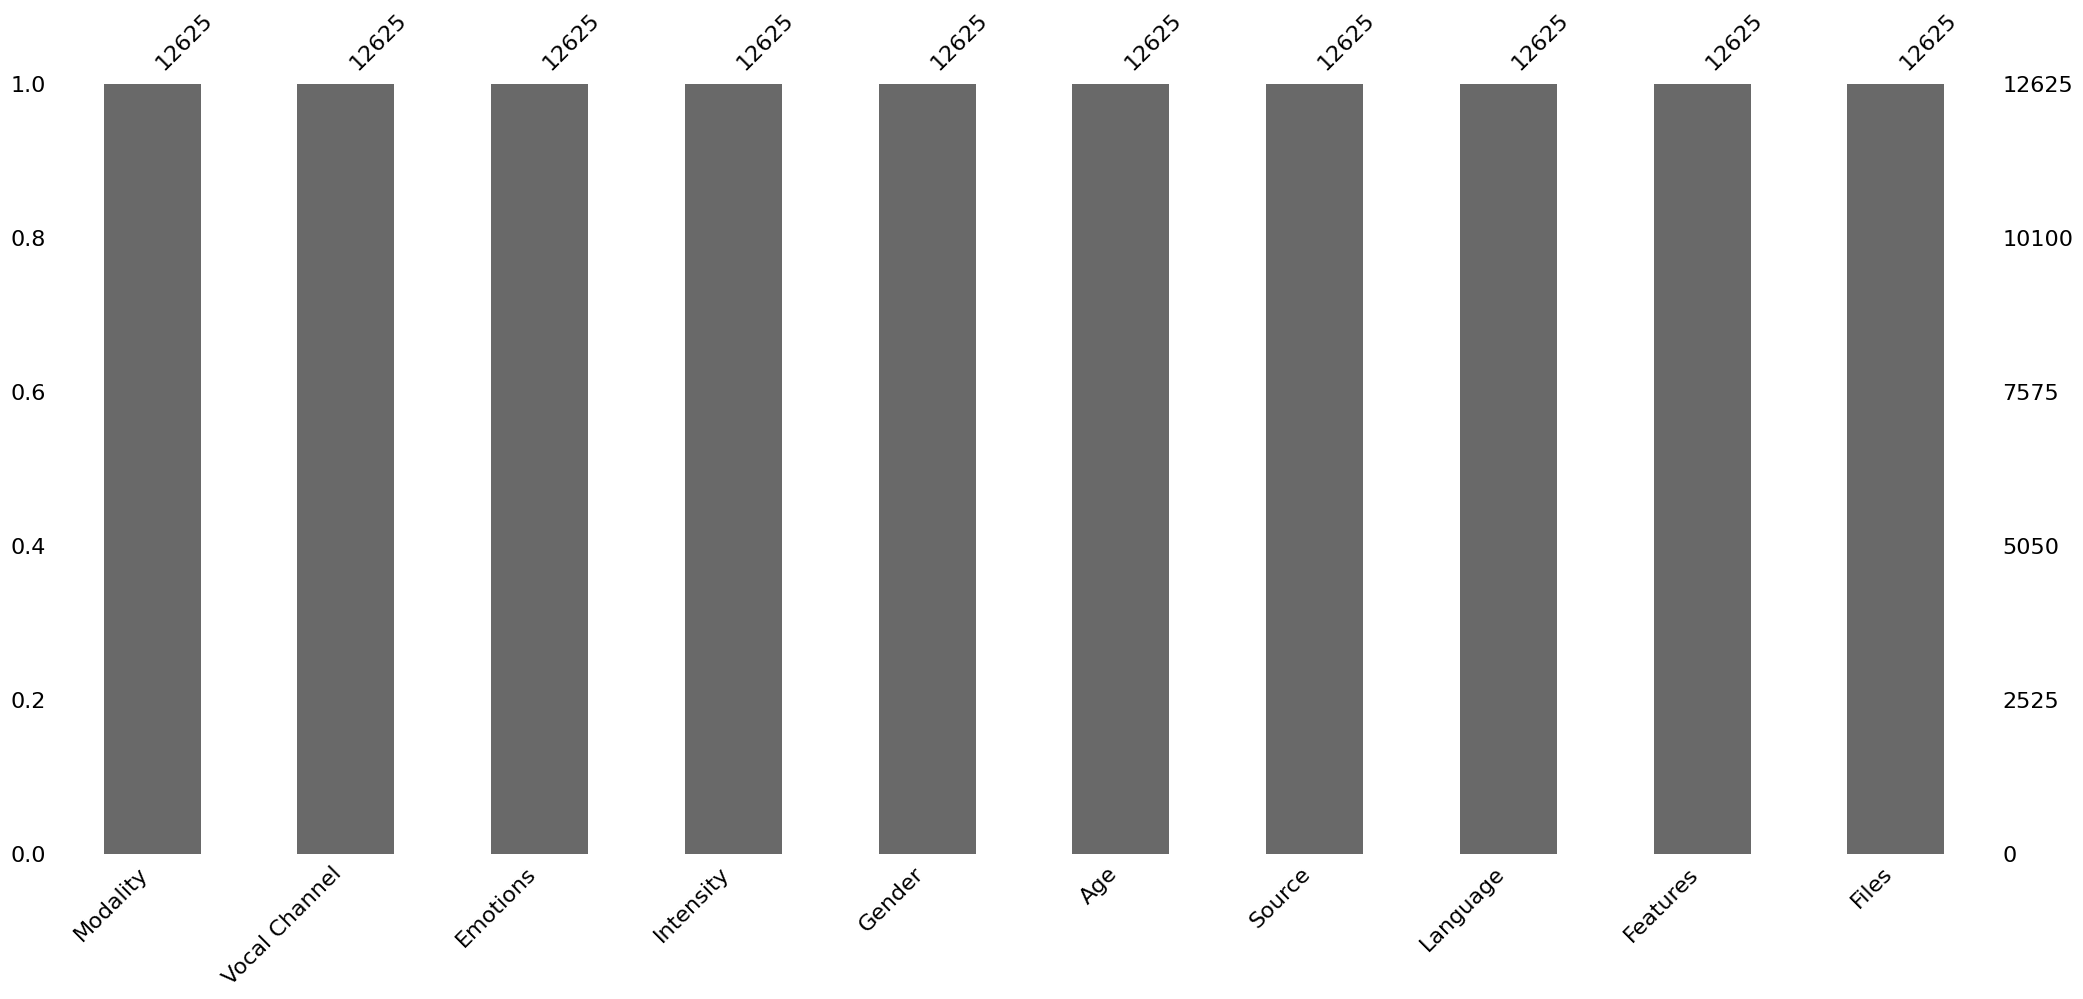

In [11]:
# Graphical representation of missing value
msno.bar(df_emotions)

In [12]:
# Datasets information
df_emotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12625 entries, 0 to 12624
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Modality       12625 non-null  object
 1   Vocal Channel  12625 non-null  object
 2   Emotions       12625 non-null  object
 3   Intensity      12625 non-null  object
 4   Gender         12625 non-null  object
 5   Age            12625 non-null  object
 6   Source         12625 non-null  object
 7   Language       12625 non-null  object
 8   Features       12625 non-null  object
 9   Files          12625 non-null  object
dtypes: object(10)
memory usage: 986.5+ KB


In [13]:
# Frequency distribution of categorical variables for Emotions
print("Emotions Attributes \n")
col_emotions = ['Modality', 'Vocal Channel', 'Emotions', 'Intensity', 'Gender', 'Age', 'Source', 'Language']
for i in col_emotions:
    print(df_emotions[i].value_counts(),"\n")

Emotions Attributes 

Modality
audio    12625
Name: count, dtype: int64 

Vocal Channel
non speech    7545
speech        5080
Name: count, dtype: int64 

Emotions
happiness         1758
surprise          1586
neutral           1568
sadness           1514
anger             1453
fear              1170
disgust            899
pain               832
boredom            542
excitement         401
pleasure           365
disappointment     365
breath             172
Name: count, dtype: int64 

Intensity
normal    10411
high       2214
Name: count, dtype: int64 

Gender
male      6915
female    5710
Name: count, dtype: int64 

Age
20-64       11009
others        744
under 20      328
above 65      294
baby          250
Name: count, dtype: int64 

Source
youtube    7471
website    2385
movies     1997
others      772
Name: count, dtype: int64 

Language
english    5743
french     3341
chinese    2503
others     1038
Name: count, dtype: int64 



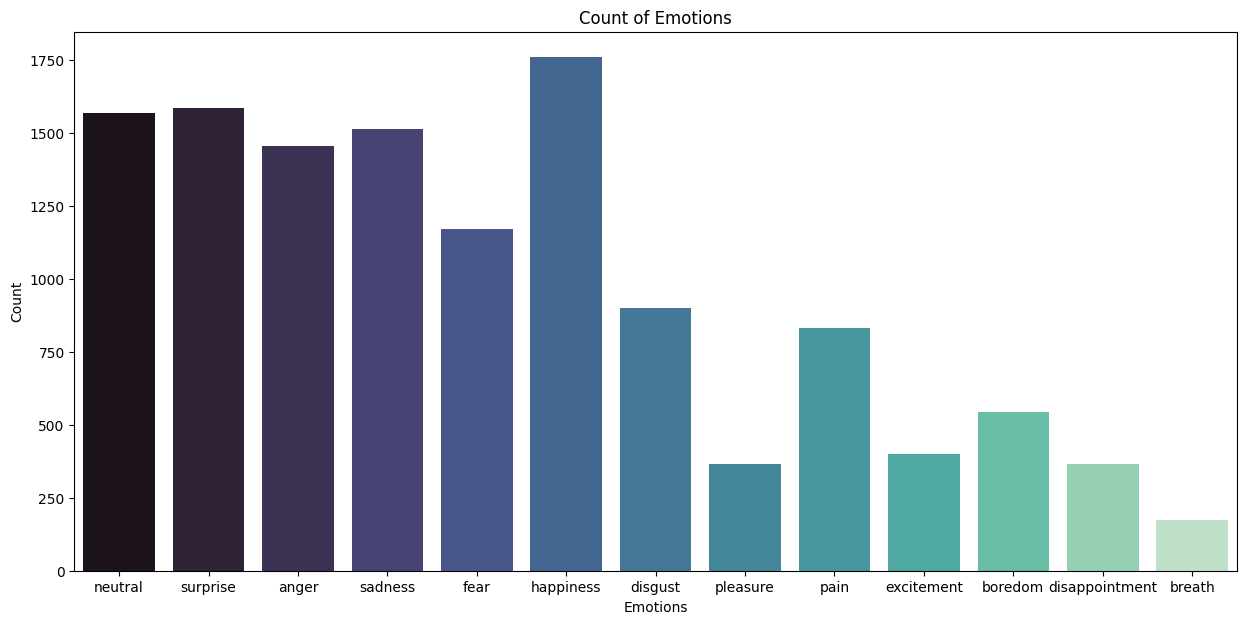

In [14]:
# Suppress FutureWarning about is_categorical_dtype
warnings.filterwarnings("ignore", category=FutureWarning)

# Set the figures of the plot
fig, ax = plt.subplots(figsize=(15, 7))

# Create a bar plot using Seaborn
sns.countplot(data=df_emotions, x='Emotions', palette='mako', ax=ax)

# Set the plot title and axis labels
plt.title('Count of Emotions')
plt.ylabel('Count')
plt.xlabel('Emotions')

# Show the plot
plt.show()

# Reset warnings filter
warnings.filterwarnings("default", category=FutureWarning)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

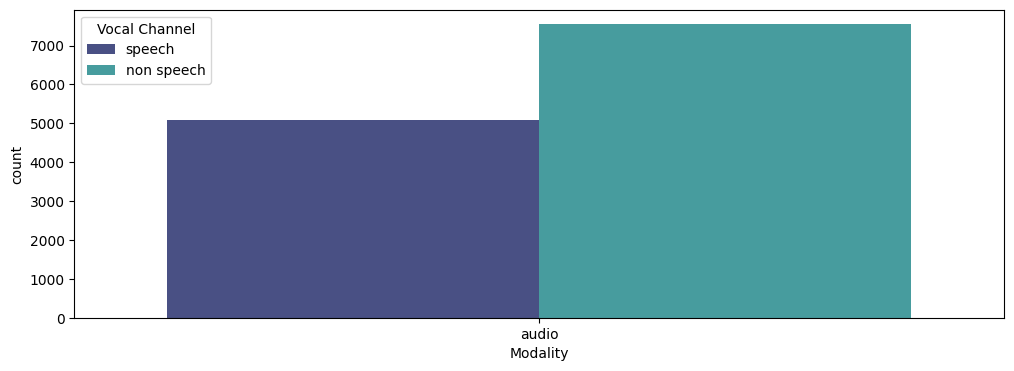

<Figure size 640x480 with 0 Axes>

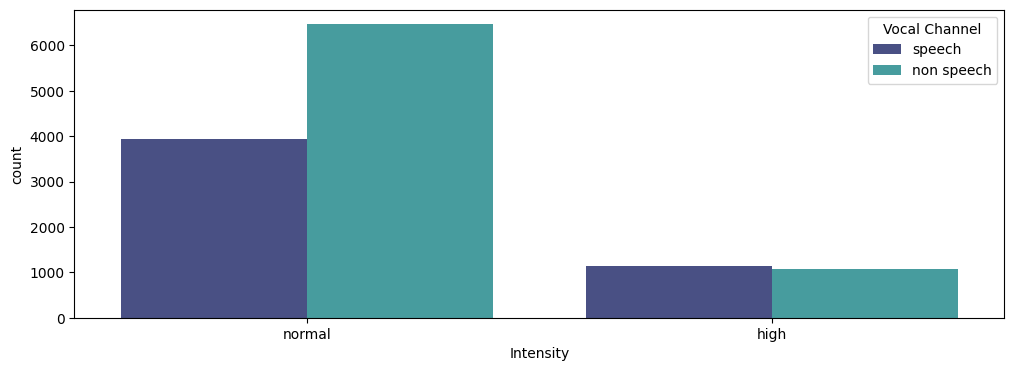

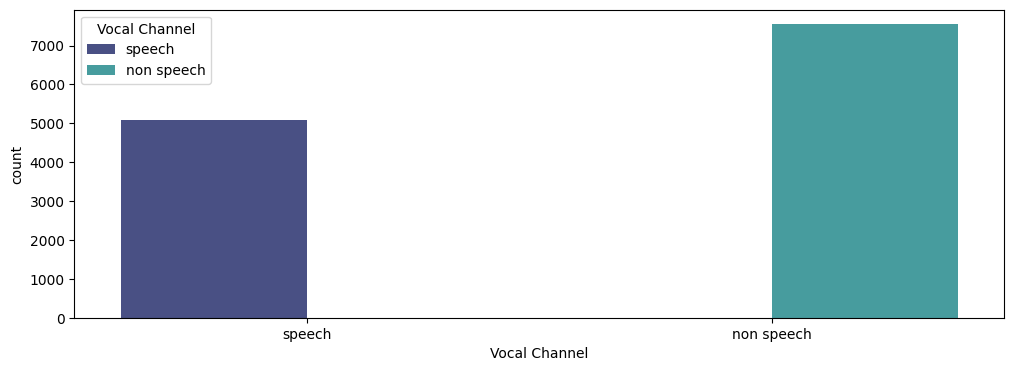

<Figure size 640x480 with 0 Axes>

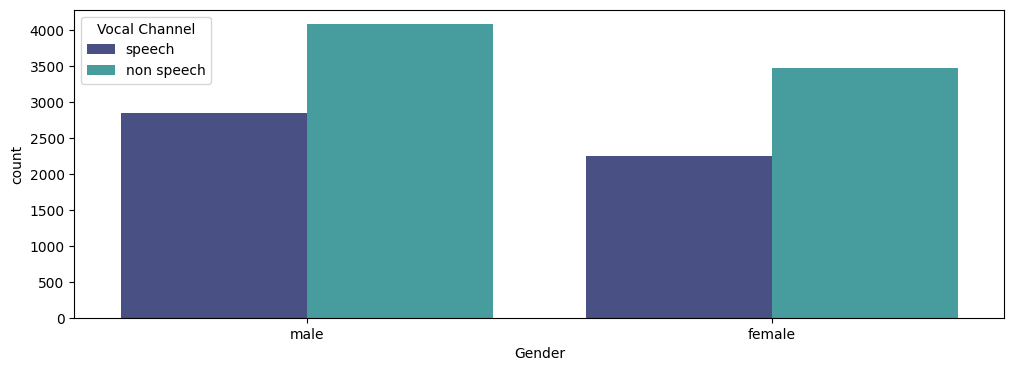

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

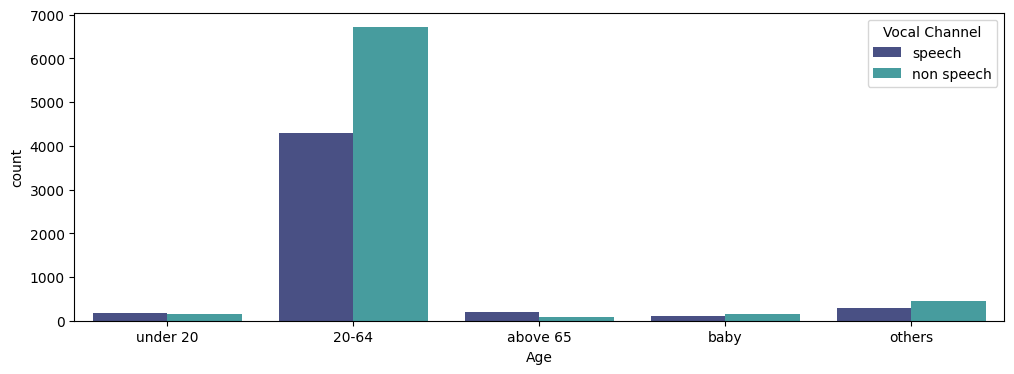

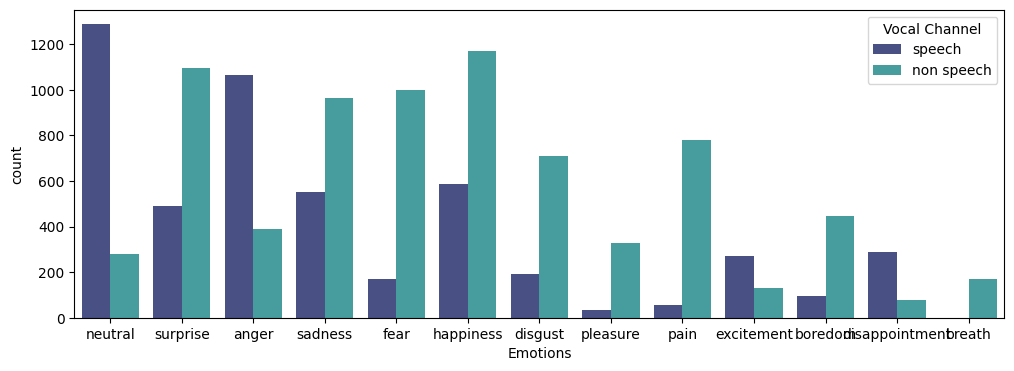

<Figure size 640x480 with 0 Axes>

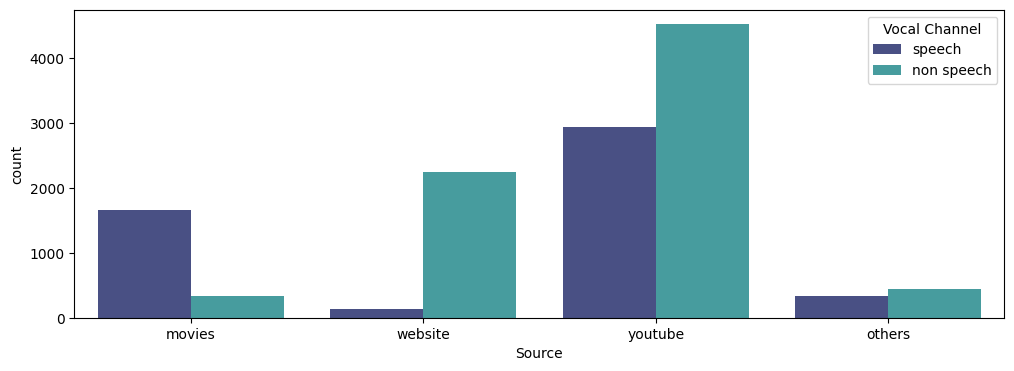

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

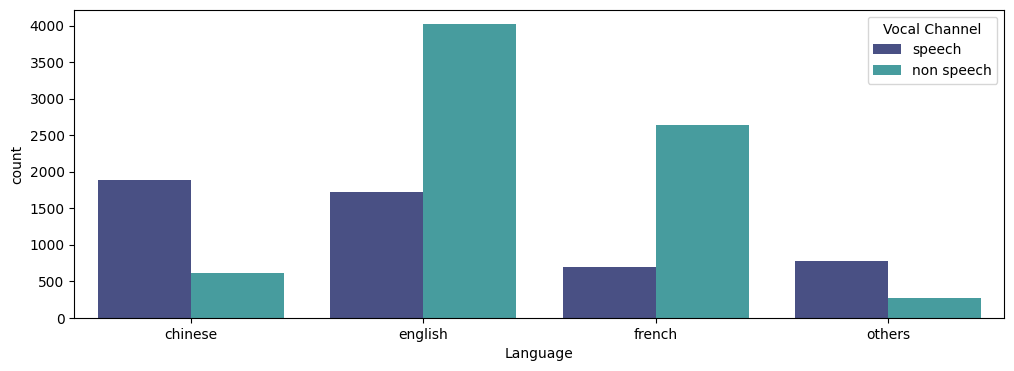

In [15]:
def freq_dist(data) :
    # This test a block of code for errors used to catch and handle exceptions
    try:
        df_std = data.select_dtypes(exclude=['int64'])
        df_excluded = df_std.iloc[:, :-2]
        for i, col in enumerate(df_excluded.columns):
            warnings.filterwarnings("ignore")
            plt.figure(i)
            # it creates a new figure for the plot
            plt.figure()
            fig, ax = plt.subplots(figsize=(12,4))
            sns.countplot(x=col, hue='Vocal Channel', data=df_excluded, ax=ax, palette='mako')
        return plt.show()
    # IOError is an exception type error that occurs when the file that we passed in as argument
    except ValueError:
            print("Invalid literal for int() with base 10 ")
            print("Kindly insert an integer value")
    except:
        print("Some other exception happened.")
freq_dist(df_emotions)

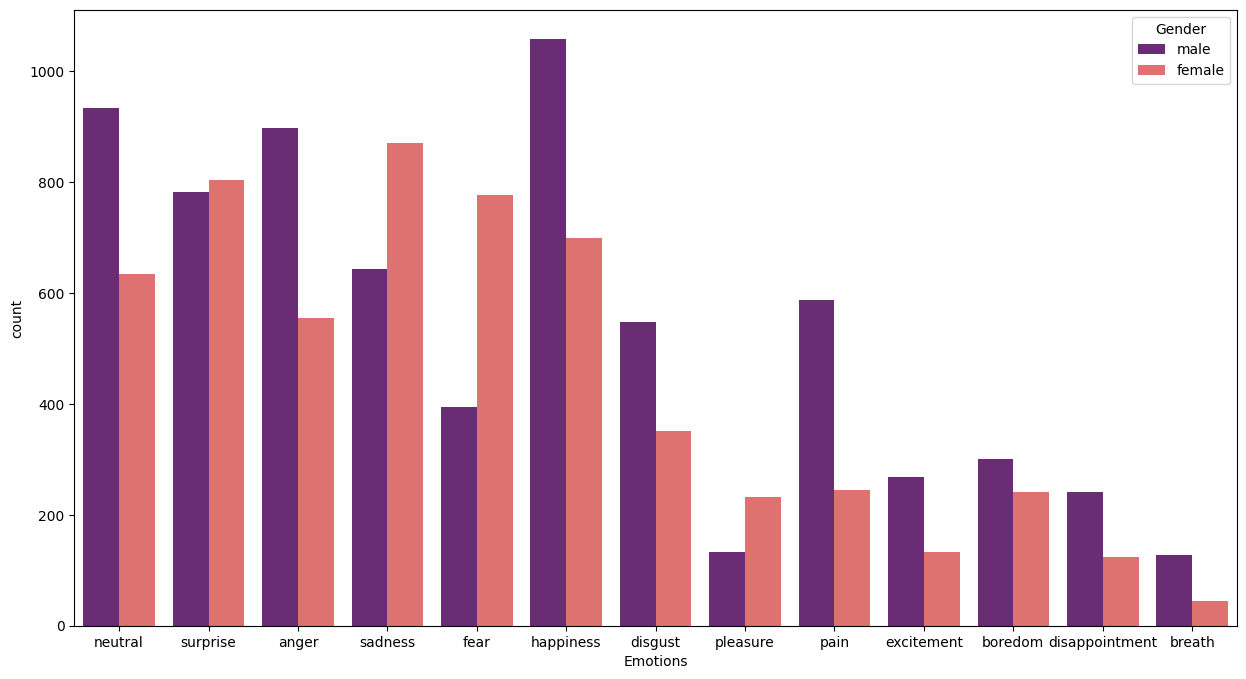

In [16]:
# Graphical representation of Emotions by Gender
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(x='Emotions', hue='Gender', data=df_emotions, palette='magma', ax=ax);

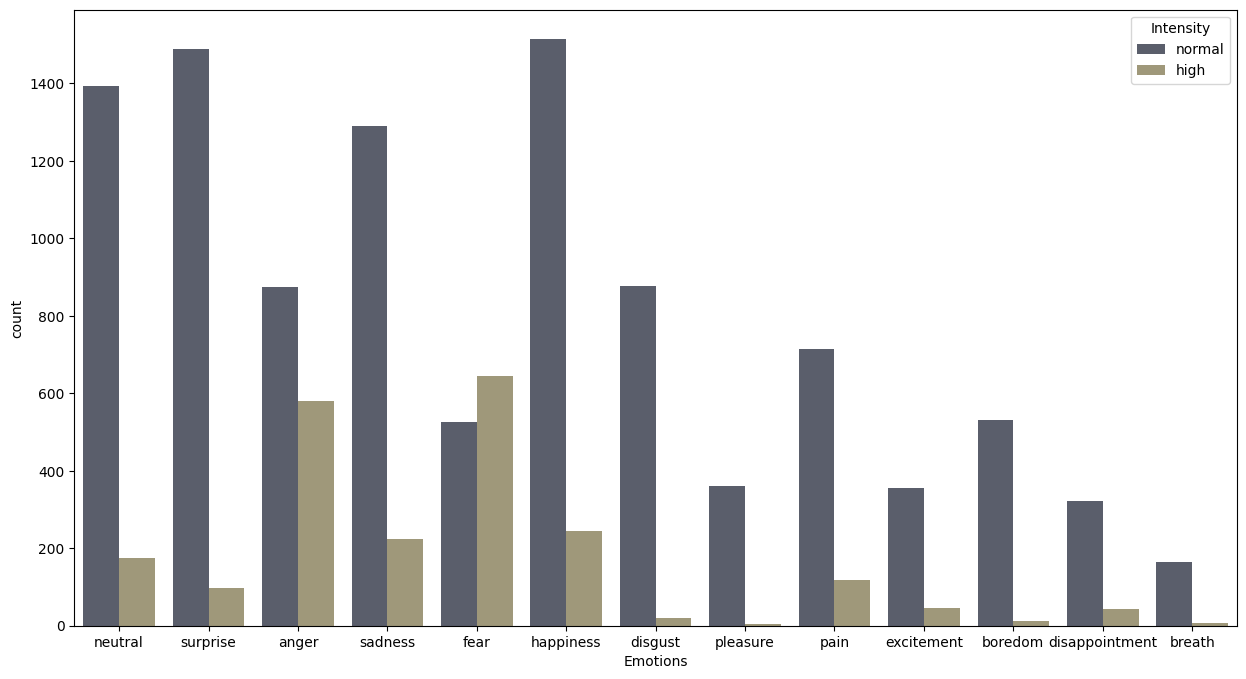

In [17]:
# Graphical representation of Emotions by Intensity
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(x='Emotions', hue='Intensity', data=df_emotions, palette='cividis', ax=ax);

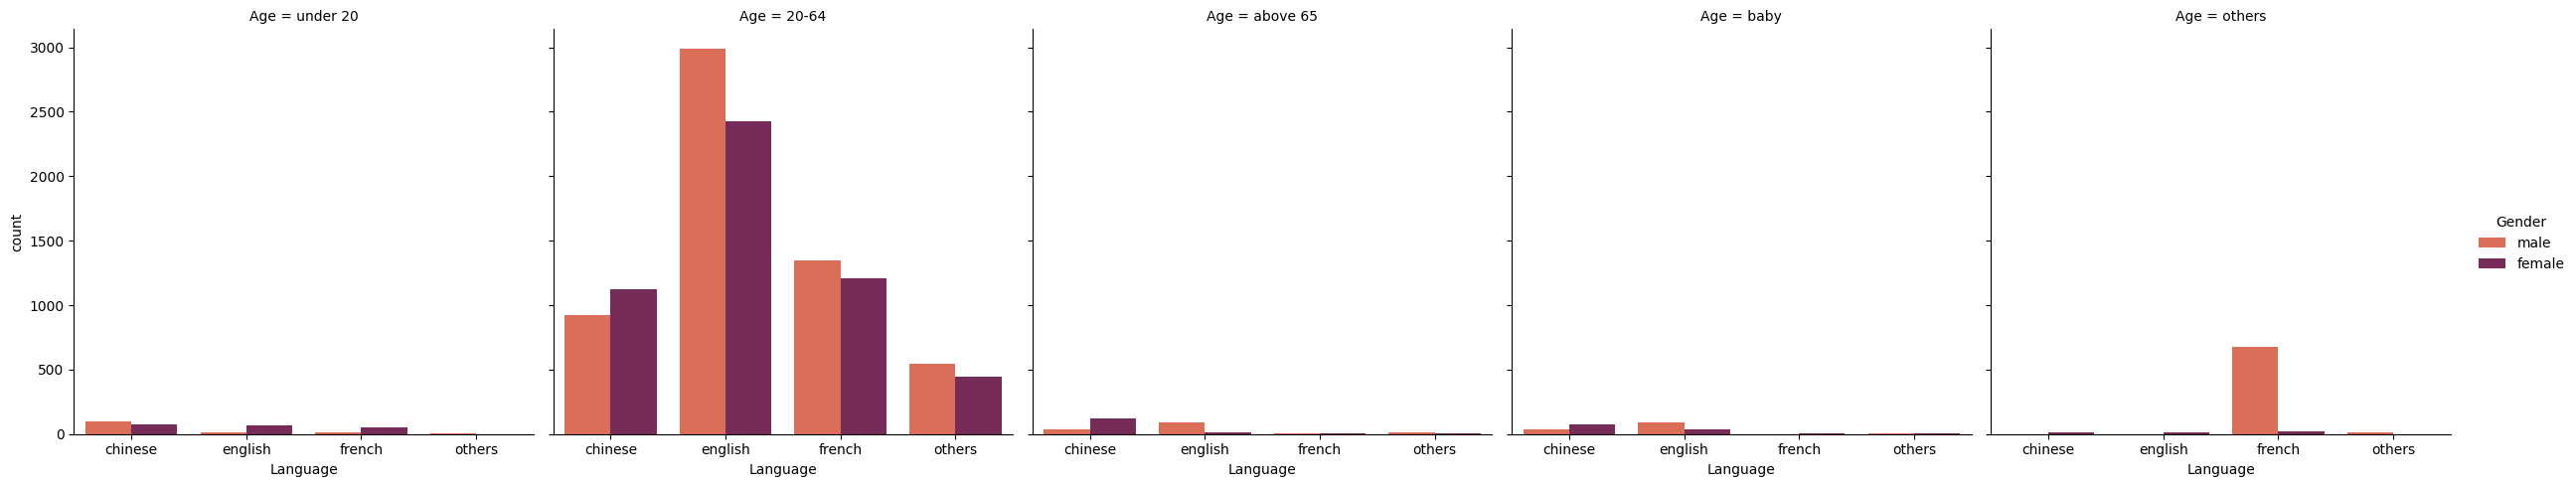

In [18]:
# Graphical representation of the Language Column on each Gender for Ages
sns.catplot(x='Language', hue='Gender', col='Age', data=df_emotions, kind='count', palette='rocket_r');

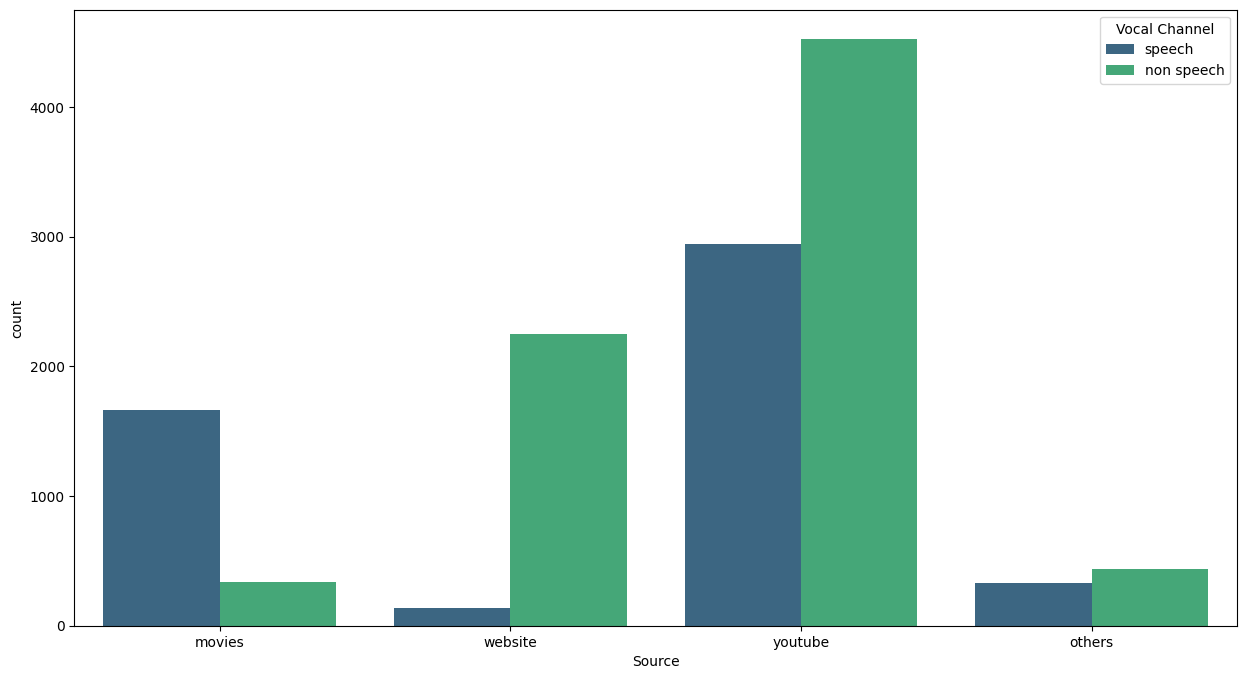

In [19]:
# Graphical representation of Source by Vocal Channel
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(x='Source', hue='Vocal Channel', data=df_emotions, palette='viridis', ax=ax);

In [20]:
# Declaring a functiopn create_wave_spect function to return plots and spectogram of each emotions
def create_wave_spect(emotion, cmap='magma'):
    path = np.array(df_emotions['Files'][df_emotions['Emotions'] == emotion])[0]
    data, sampling_rate = librosa.load(path)
    
    # Plot of waveform
    plt.figure(figsize=(15, 4))
    plt.title('Waveplot for {} emotion'.format(emotion.capitalize()), size=15)
    # librosa.display.waveshow(data, sr=sampling_rate)
    plt.plot(data, color='b')
    plt.show()
    
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    # Plot of spectogram
    plt.figure(figsize=(15, 4))
    plt.title('Spectrogram for {} emotion'.format(emotion.capitalize()), size=15)
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz', cmap=cmap)
    plt.colorbar()
    plt.show()
    
    display(Audio(path))

Plots of Boredom


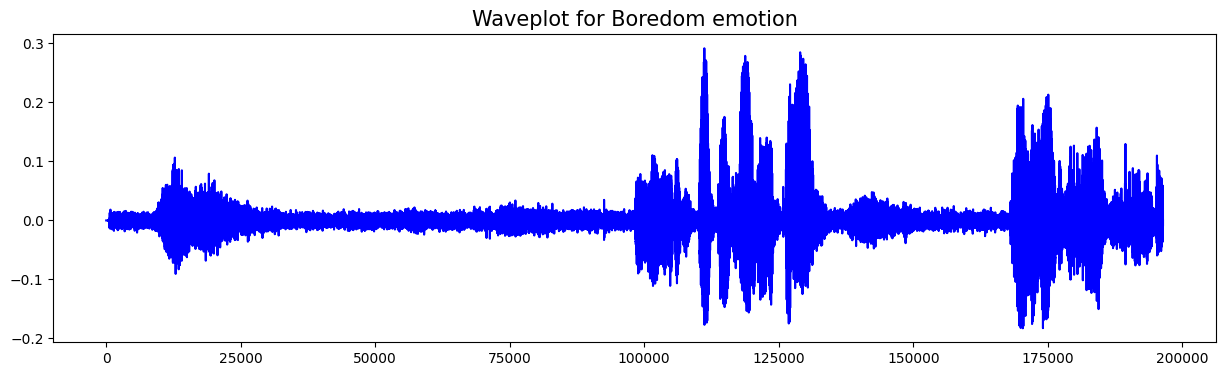

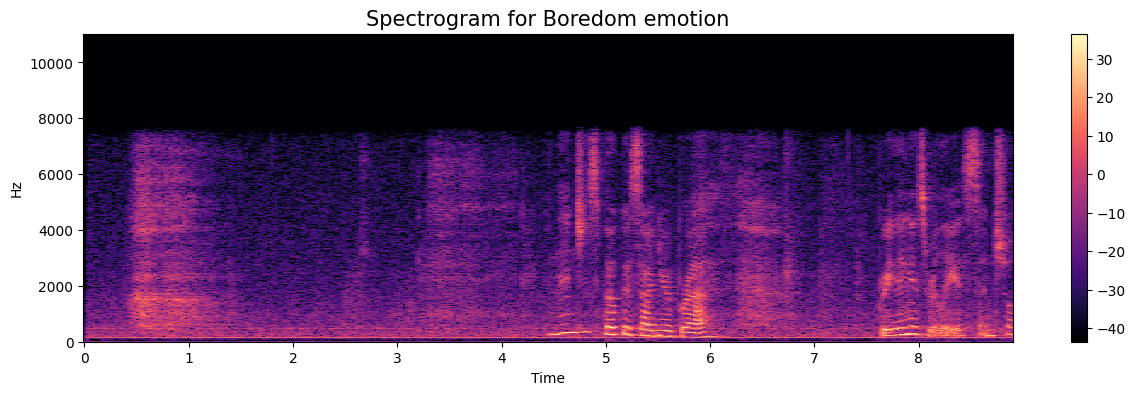

Plots of Neutral


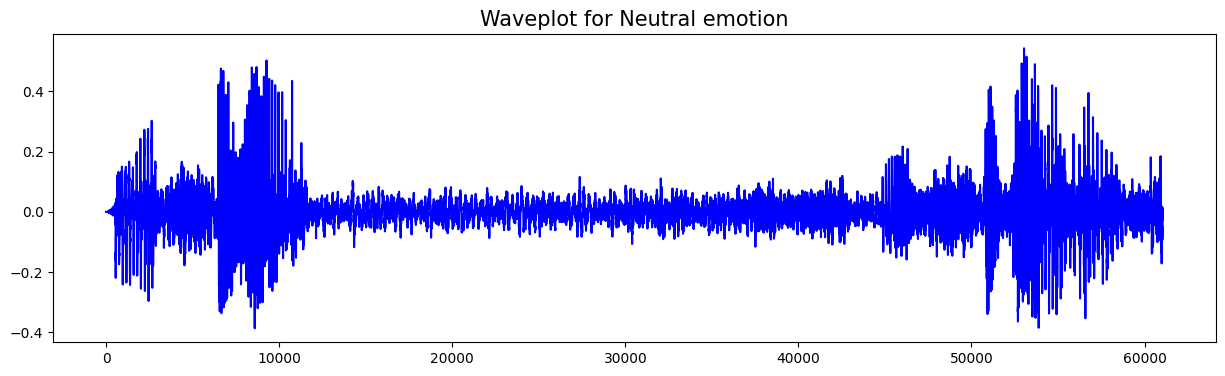

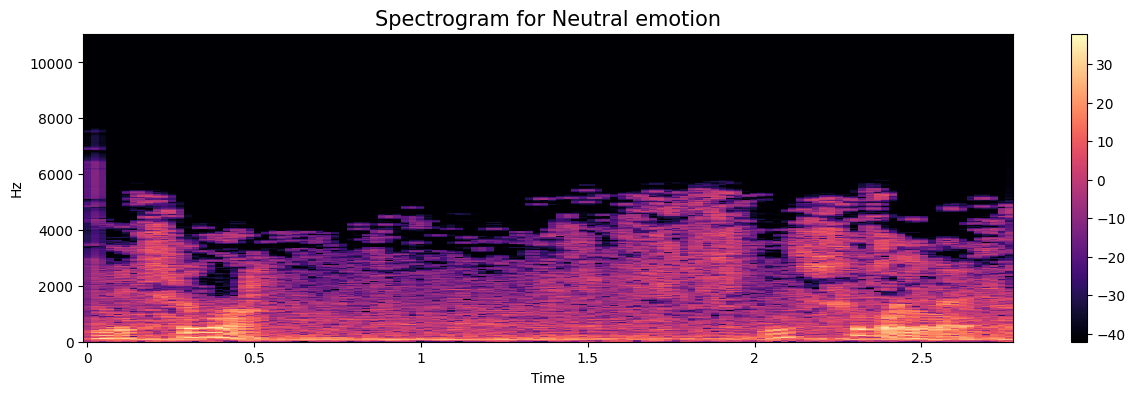

Plots of Happiness


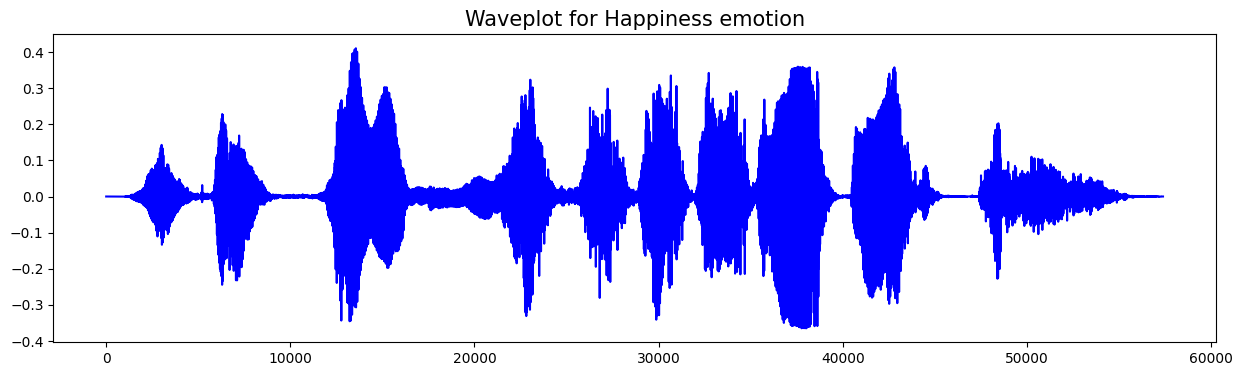

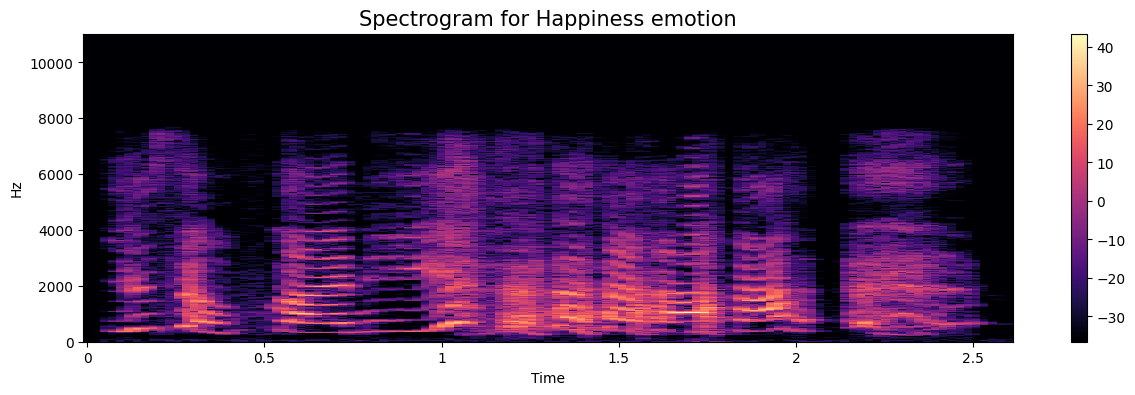

Plots of Sadness


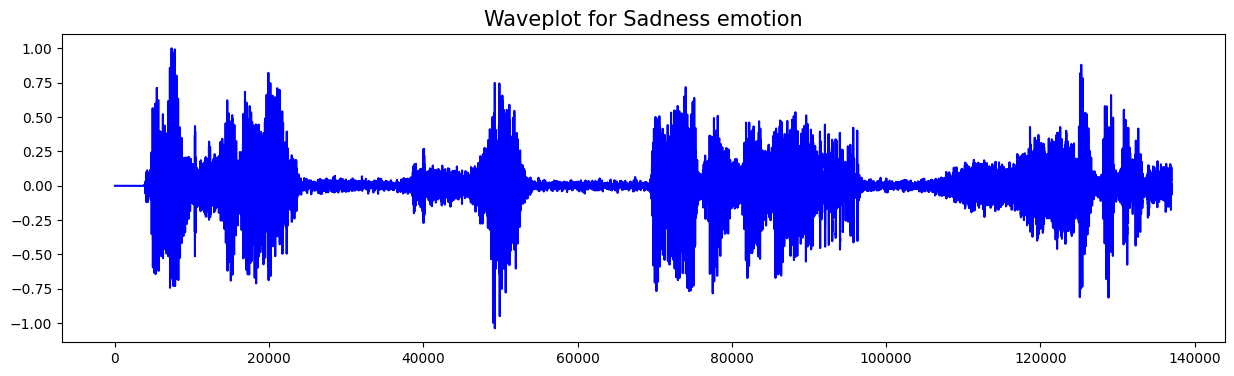

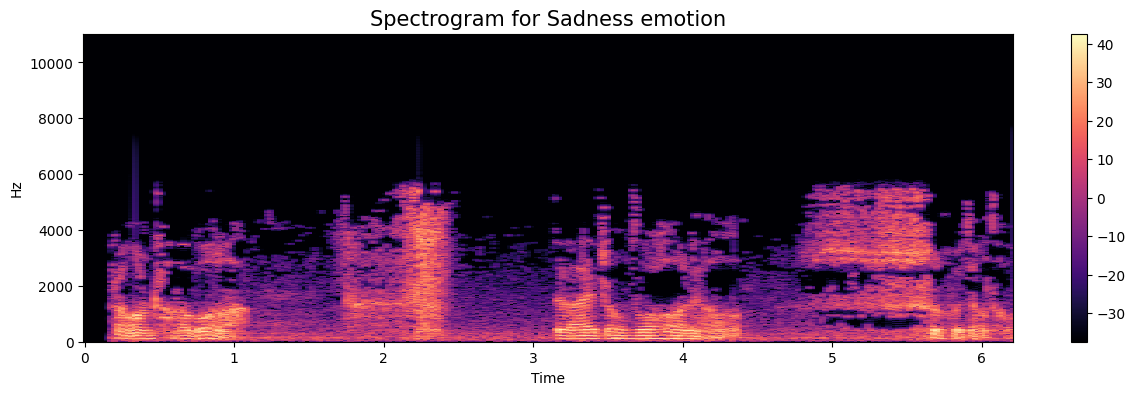

Plots of Anger


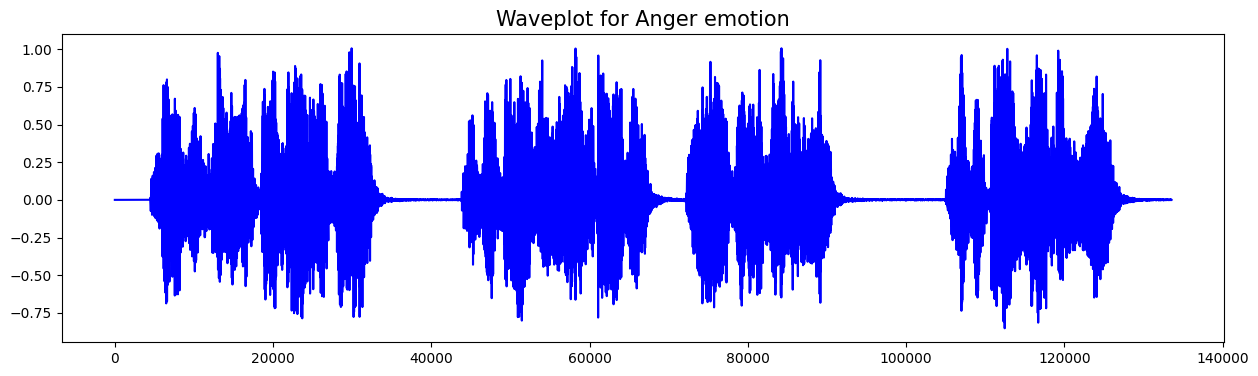

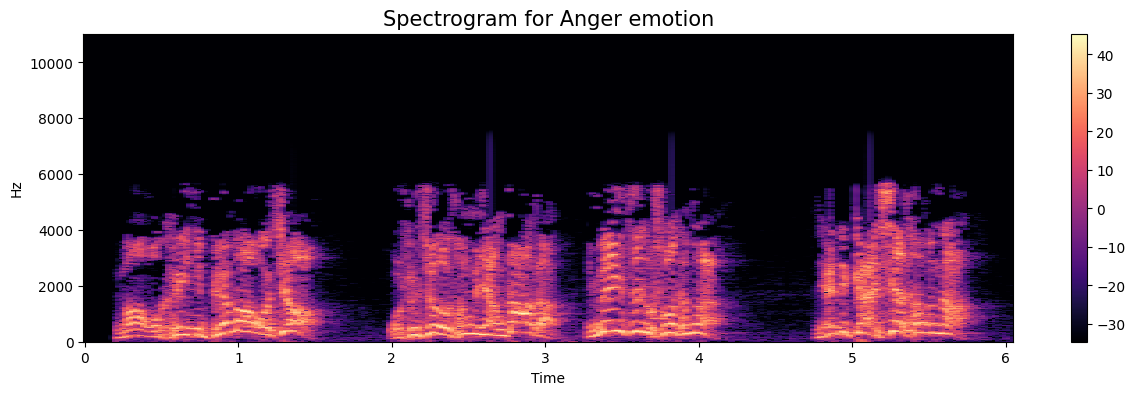

Plots of Fear


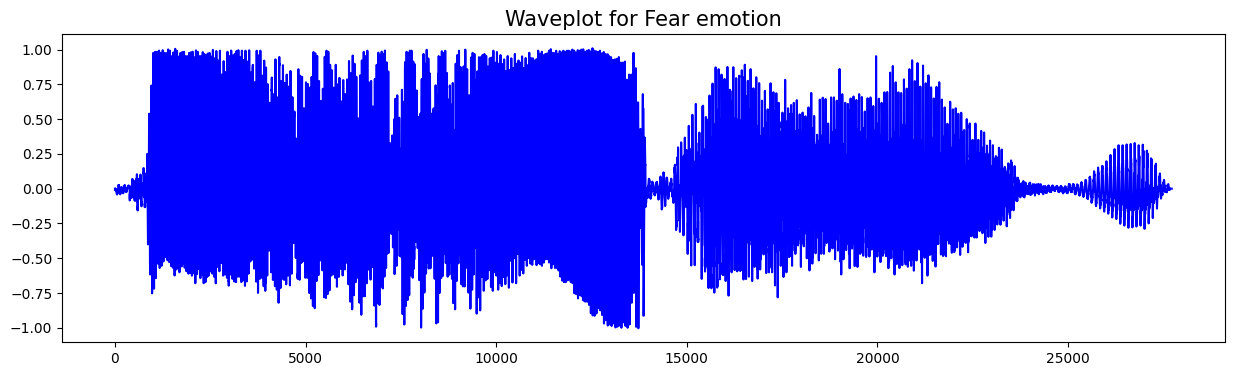

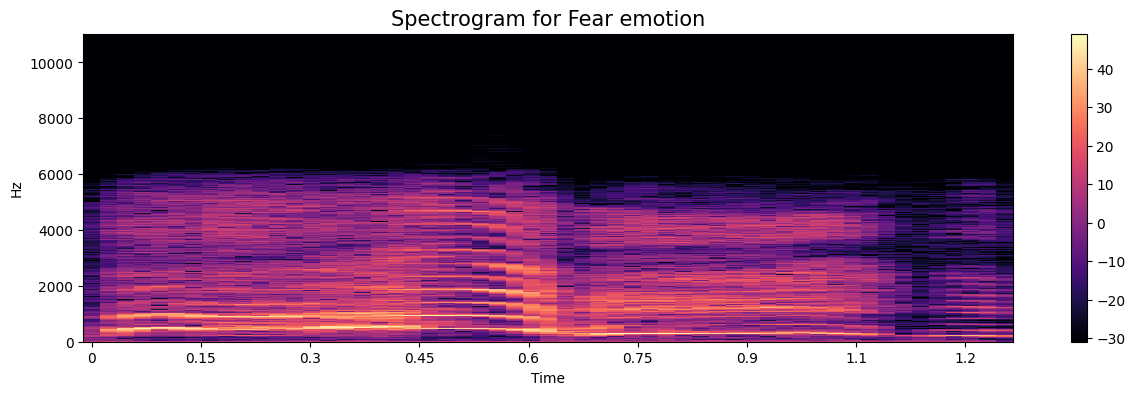

Plots of Disgust


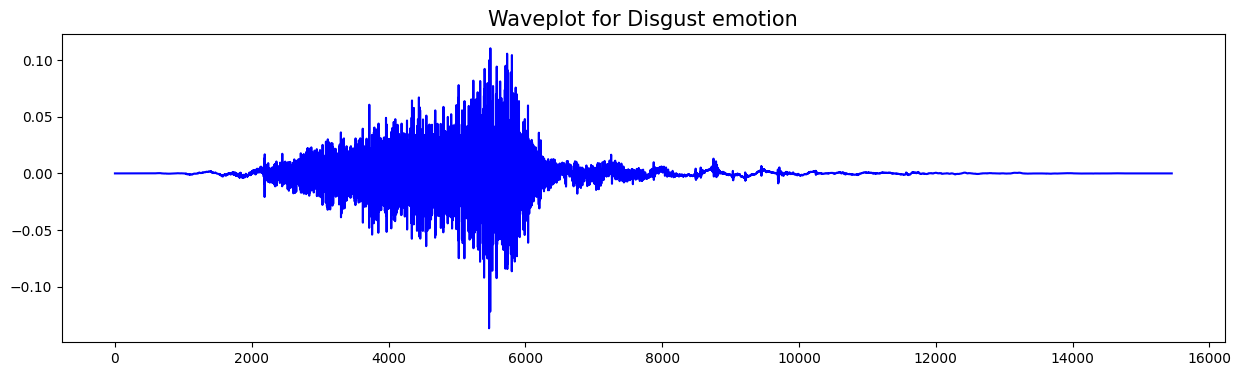

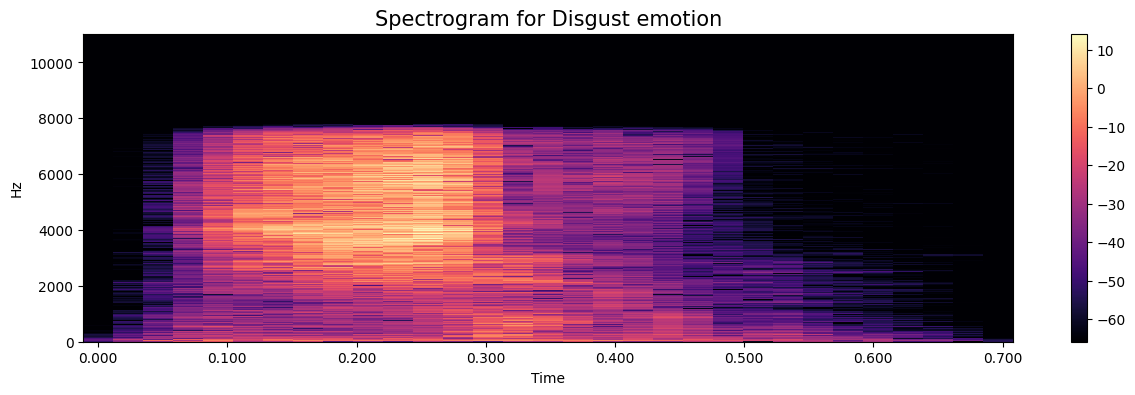

Plots of Surprise


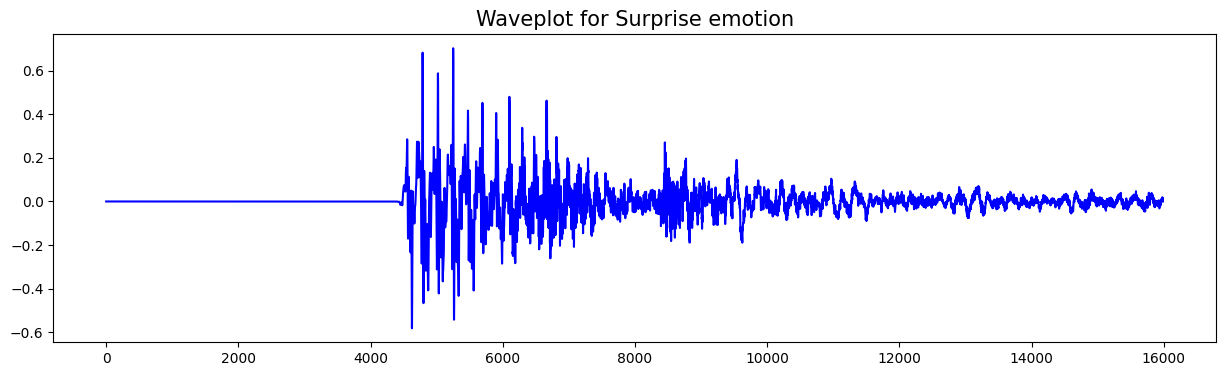

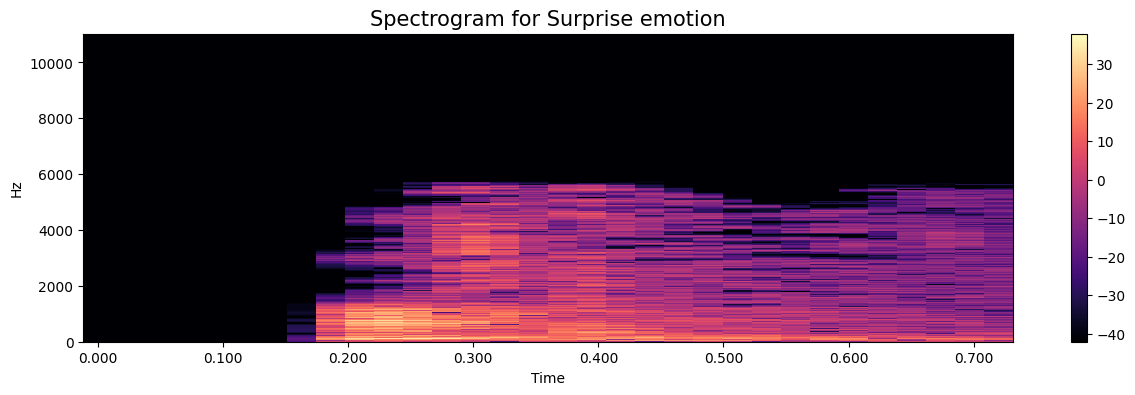

Plots of Excitement


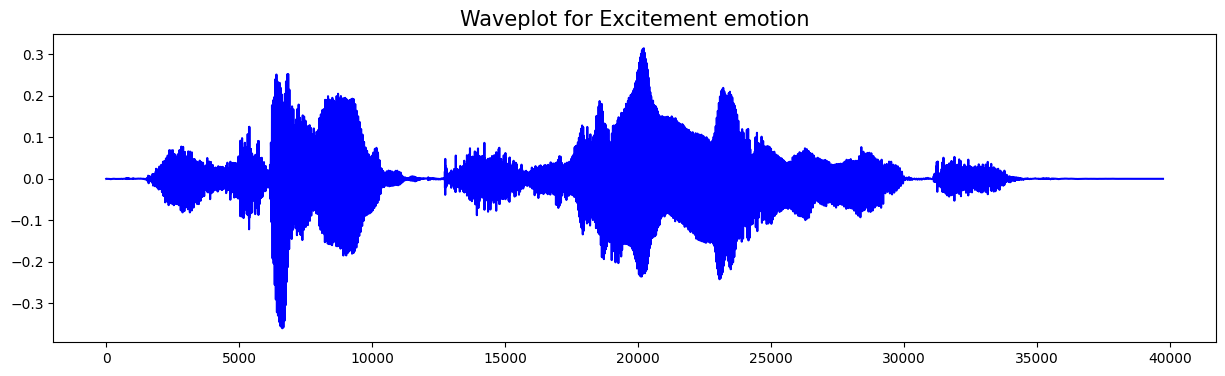

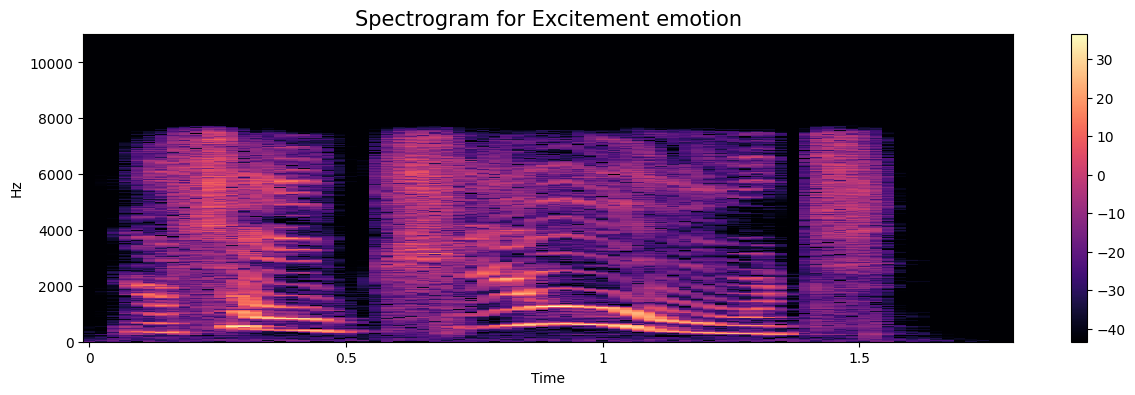

Plots of Pleasure


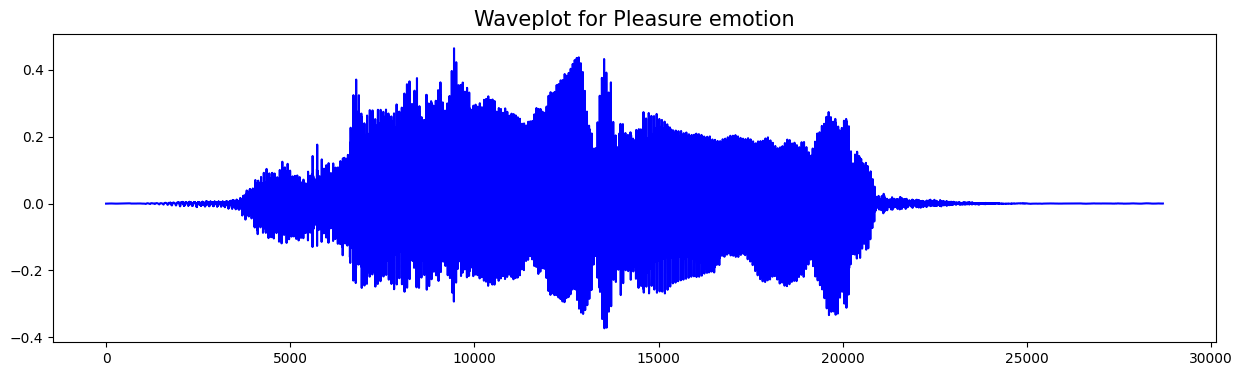

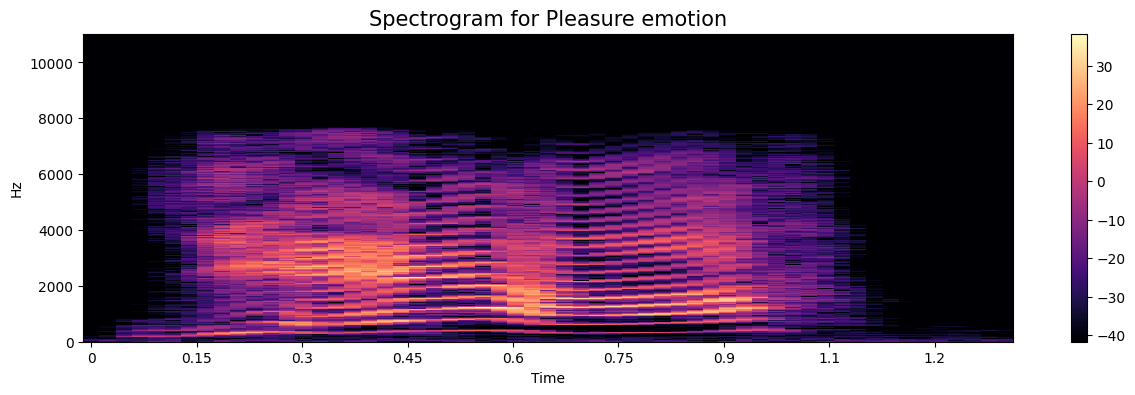

Plots of Pain


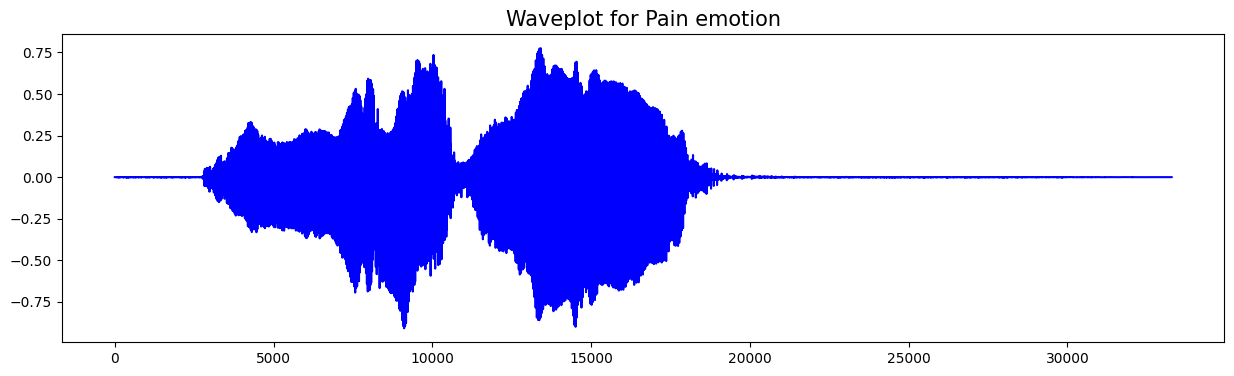

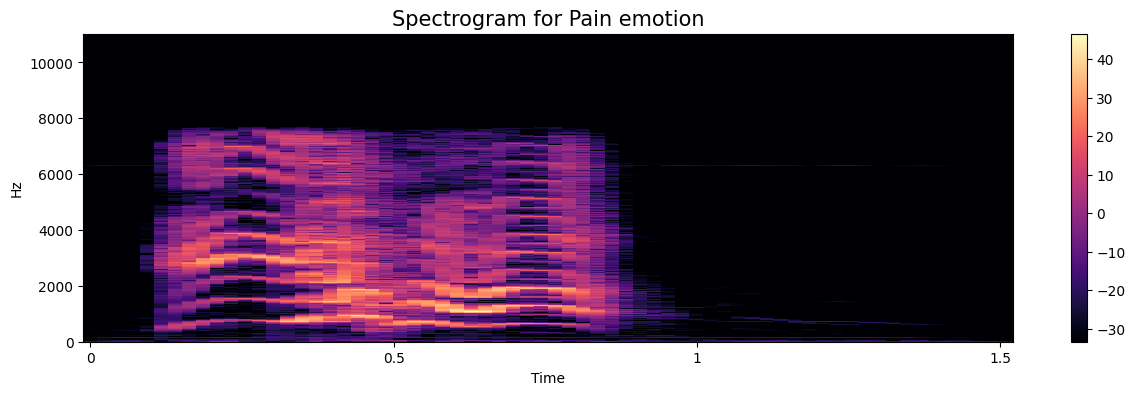

Plots of Disappointment


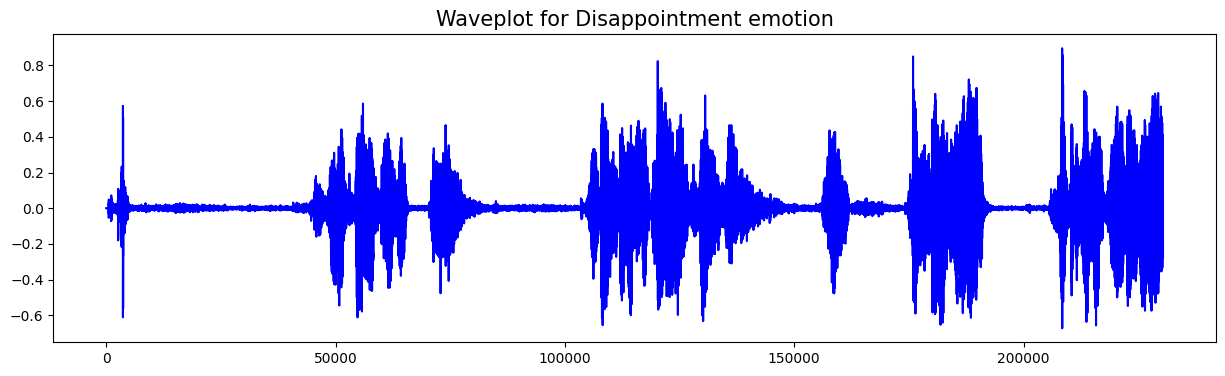

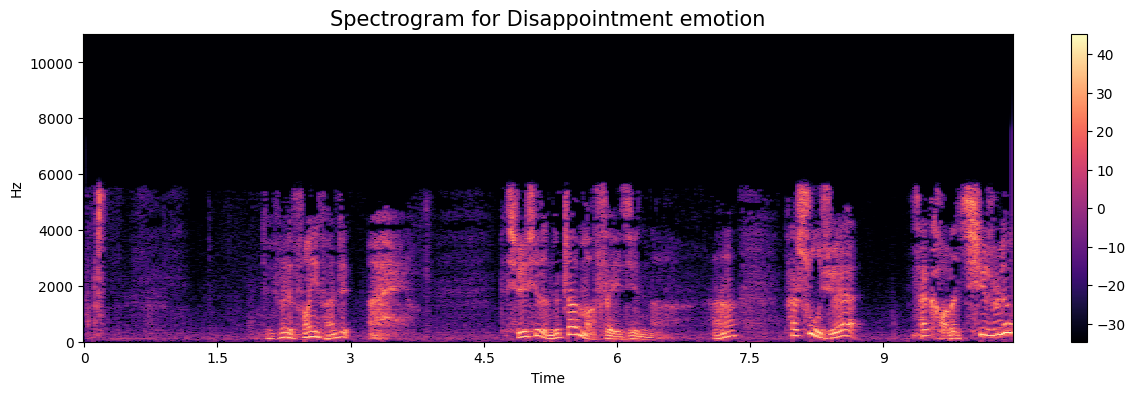

Plots of Breath


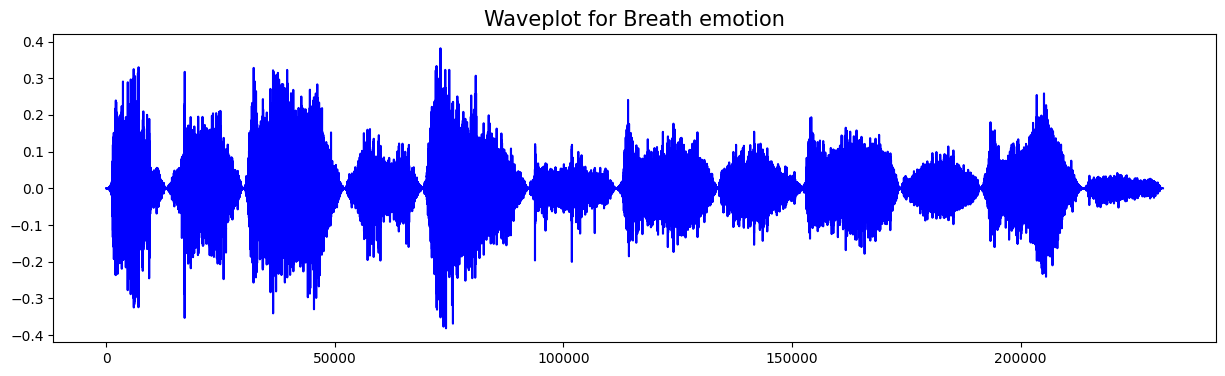

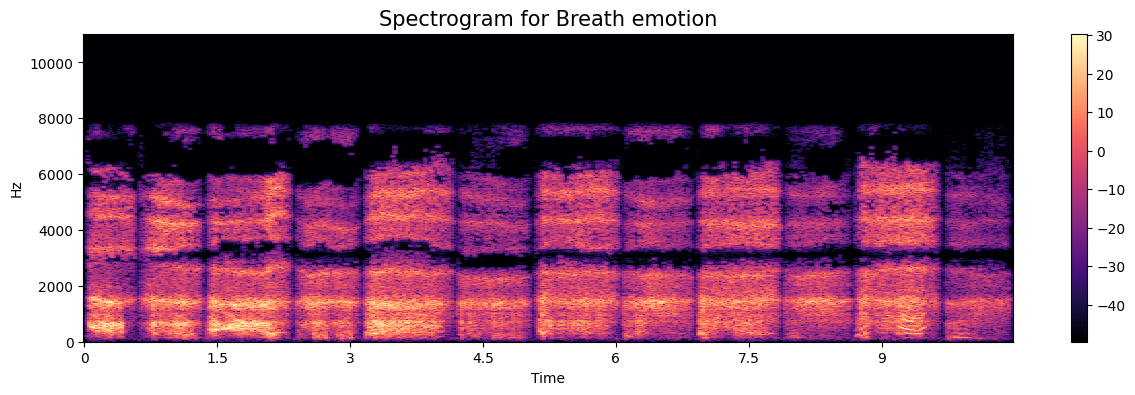

In [21]:
# List of emotions
emotions = ["boredom", "neutral", "happiness", "sadness", "anger", "fear", "disgust", "surprise", "excitement", "pleasure", "pain", "disappointment", "breath"]

# Loop through emotions and create/display plots
for emotion in emotions:
    print('Plots of', emotion.capitalize())
    create_wave_spect(emotion, cmap='magma')

Data Augmentation

In [22]:
# Define the augment_audio function
def augment_audio(audio, sr):
    # Time stretching (stretch the audio in time)
    time_stretch = librosa.effects.time_stretch(audio, rate=1.2)  # Adjust the rate
    
    # Pitch shifting (change the pitch of the audio)
    pitch_shift = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)  # Provide sr here and adjust n_steps
    
    # Adding random noise
    noise = np.random.normal(0, 0.02, len(audio))  # Adjust the noise level
    
    # Combine the augmented versions
    augmented_audio = audio[:min(len(audio), len(time_stretch), len(pitch_shift))] + \
                     time_stretch[:min(len(audio), len(time_stretch), len(pitch_shift))] + \
                     pitch_shift[:min(len(audio), len(time_stretch), len(pitch_shift))] + \
                     noise[:min(len(audio), len(time_stretch), len(pitch_shift))]
    
    return augmented_audio

In [23]:
# Define the output directory for augmented audio files
output_directory = working_directory + '/Augmented_audio'

# Loop through your dataset and apply augmentation to each audio file
# for root, dirs, files in os.walk(dataset_path):
#     for file in files:
#         audio_path = os.path.join(root, file)
#         if not audio_path.endswith(".wav"):
#             print(f"Skipping non-wav file: {audio_path}")
#             continue
#         try:
#             audio, sr = librosa.load(audio_path, sr=None)
            
#             # Augment the audio
#             augmented_audio = augment_audio(audio, sr)
            
#             # Define a new filename for the augmented audio in the output directory
#             output_filename = os.path.join(output_directory, file.replace('.wav', '_augmented.wav'))
            
#             # Save the augmented audio to the output directory
#             sf.write(output_filename, augmented_audio, sr)
#             # print(f"Augmented and saved to: {output_filename}")
#         except Exception as e:
#             print(f"Error augmenting {audio_path}: {str(e)}")

Feature Engineering

In [24]:
# Load and preprocess your dataset from df_emotions (replace with your data loading code)
def load_and_preprocess_data():
    # Assuming df_emotions has columns 'Files' for file paths, 'Emotions' for emotion labels, and 'Features' for MFCCs
    mfcc_features = df_emotions['Features'].tolist()
    emotions = df_emotions['Emotions'].tolist()

    return mfcc_features, emotions

Support Vector Machine (SVM)

In [25]:
# Load and preprocess the dataset
X_mfcc_features, y = load_and_preprocess_data()

# Check the shapes of MFCC features
mfcc_shapes = [mfcc.shape for mfcc in X_mfcc_features]

# Verify if all MFCC feature shapes are the same
if all(shape == mfcc_shapes[9] for shape in mfcc_shapes):
    print("MFCC shapes are consistent:", mfcc_shapes[0])
else:
    print("MFCC shapes are not consistent:", mfcc_shapes)

# Pad MFCC sequences to have the same length (use the maximum sequence length)
max_length = max([len(mfcc) for mfcc in X_mfcc_features])
X_mfcc_features_padded = pad_sequences(X_mfcc_features, maxlen=342, padding='post', dtype='float32')

# Reshape the features to 2D (number of samples, number of features)
features_reshaped = X_mfcc_features_padded.reshape(X_mfcc_features_padded.shape[0], -1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_reshaped, y, test_size=0.2, random_state=42
)

MFCC shapes are not consistent: [(87, 13), (23, 13), (190, 13), (115, 13), (27, 13), (98, 13), (195, 13), (119, 13), (72, 13), (342, 13), (343, 13), (42, 13), (30, 13), (357, 13), (164, 13), (342, 13), (190, 13), (123, 13), (72, 13), (41, 13), (342, 13), (40, 13), (83, 13), (31, 13), (82, 13), (26, 13), (22, 13), (60, 13), (35, 13), (23, 13), (342, 13), (329, 13), (342, 13), (69, 13), (24, 13), (85, 13), (23, 13), (127, 13), (47, 13), (72, 13), (70, 13), (45, 13), (64, 13), (69, 13), (119, 13), (47, 13), (46, 13), (31, 13), (36, 13), (36, 13), (169, 13), (41, 13), (55, 13), (328, 13), (113, 13), (409, 13), (62, 13), (65, 13), (69, 13), (18, 13), (96, 13), (42, 13), (148, 13), (61, 13), (48, 13), (342, 13), (102, 13), (85, 13), (185, 13), (342, 13), (32, 13), (145, 13), (37, 13), (45, 13), (87, 13), (32, 13), (125, 13), (75, 13), (154, 13), (271, 13), (123, 13), (133, 13), (23, 13), (37, 13), (19, 13), (46, 13), (342, 13), (107, 13), (57, 13), (91, 13), (93, 13), (49, 13), (342, 13), (3

In [26]:
# Create a machine learning pipeline with feature scaling and an SVM classifier
model_svm = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features to have mean=0 and variance=1
    ('pca', PCA(n_components=50)),  # Principal Component Analysis (PCA) for dimensionality reduction
    ('svm', SVC(kernel='linear', C=1.0))  # Support Vector Machine with a linear kernel
])

# Fit the model
model_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy for SVM :', round(accuracy,3) * 100 ,'%')

# Generate a classification report and confusion matrix
report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

confusion_svm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', confusion_svm)

Test Accuracy for SVM : 36.199999999999996 %
Classification Report:
                 precision    recall  f1-score   support

         anger       0.40      0.30      0.35       284
       boredom       0.13      0.03      0.04       117
        breath       0.71      0.16      0.26        31
disappointment       0.00      0.00      0.00        82
       disgust       0.09      0.02      0.04       169
    excitement       0.00      0.00      0.00        80
          fear       0.57      0.57      0.57       225
     happiness       0.37      0.37      0.37       369
       neutral       0.40      0.35      0.38       320
          pain       0.29      0.11      0.16       175
      pleasure       0.31      0.06      0.10        67
       sadness       0.51      0.56      0.54       285
      surprise       0.26      0.79      0.39       321

      accuracy                           0.36      2525
     macro avg       0.31      0.26      0.25      2525
  weighted avg       0.34      0.

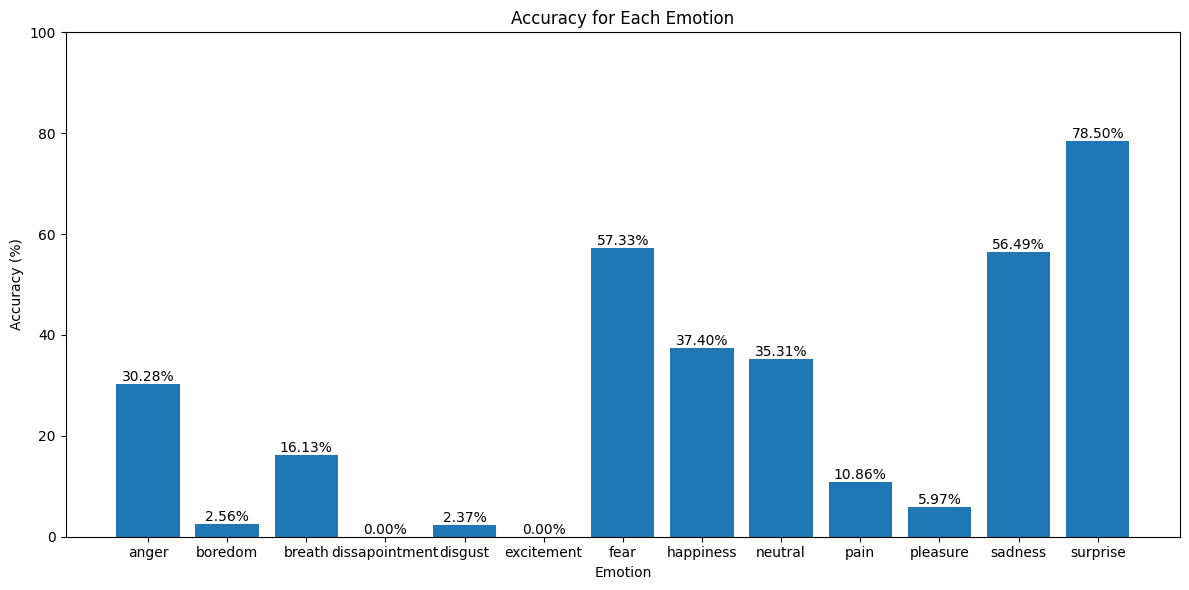

In [27]:
# Calculate accuracy for each emotion SVM
accuracies = []

# Define emotion labels
emotion_labels_svm = ['anger', 'boredom', 'breath', 'dissapointment', 'disgust', 'excitement', 'fear', 'happiness', 'neutral', 'pain', 'pleasure', 'sadness', 'surprise']

for i in range(len(emotion_labels_svm)):
    correct_predictions = confusion_svm[i, i]
    total_predictions = sum(confusion_svm[i, :])  # Sum of the row for class i
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracies.append(accuracy)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(emotion_labels_svm, [accuracy * 100 for accuracy in accuracies])  # Convert accuracies to percentages
plt.xlabel('Emotion')
plt.ylabel('Accuracy (%)')  # Change the ylabel to 'Accuracy (%)'
plt.title('Accuracy for Each Emotion')
plt.ylim(0, 100)  # Set the y-axis limit to the range [0, 100]

# Display the accuracy values on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy * 100, f'{accuracy * 100:.2f}%', ha='center', va='bottom')  # Convert accuracy to percentage

# Show the plot
plt.tight_layout()
plt.show()

Convolutional Neural Networks (CNNs)

In [28]:
# Load and preprocess the dataset
X_mfcc_features, y_labels = load_and_preprocess_data()

# Encode emotion labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

# Pad MFCC sequences to have the same length (use the maximum sequence length)
max_length = max([len(mfcc) for mfcc in X_mfcc_features])
X_mfcc_features_padded = pad_sequences(X_mfcc_features, maxlen=max_length, padding='post', dtype='float32')

# Convert X_mfcc_features_padded to a NumPy array
X_mfcc_features_padded = np.array(X_mfcc_features_padded)

# Define the number of classes (emotions)
num_classes = len(label_encoder.classes_)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mfcc_features_padded, y_encoded, test_size=0.2, random_state=42)

In [29]:
# Define the CNN model
model_cnn = Sequential([
    Input(shape=X_mfcc_features_padded.shape[1:]),  # Input shape based on your MFCC feature dimension
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer with classes based on your emotion categories
])

# Compile the model
model_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy for integer-encoded labels
              metrics=['accuracy'])

# Train the model
model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
print(f'Test Accuracy for CNNs :', round(test_acc,3) * 100 ,'%')

# Make predictions
y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Decode encoded labels back to original emotions
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Generate a classification report and confusion matrix
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    report_cnn = classification_report(y_test_original, y_pred_original)
print('Classification Report:\n', report_cnn)

confusion_cnn = confusion_matrix(y_test_original, y_pred_original)
print('Confusion Matrix:\n', confusion_cnn)

Epoch 1/10
253/253 [==============================] - 6s 20ms/step - loss: 3.2904 - accuracy: 0.2106 - val_loss: 2.1014 - val_accuracy: 0.3139
Epoch 2/10
253/253 [==============================] - 5s 21ms/step - loss: 2.1728 - accuracy: 0.2666 - val_loss: 2.0786 - val_accuracy: 0.3257
Epoch 3/10
253/253 [==============================] - 5s 21ms/step - loss: 2.0846 - accuracy: 0.2952 - val_loss: 1.9354 - val_accuracy: 0.3480
Epoch 4/10
253/253 [==============================] - 5s 21ms/step - loss: 1.9851 - accuracy: 0.3355 - val_loss: 1.8613 - val_accuracy: 0.3842
Epoch 5/10
253/253 [==============================] - 5s 22ms/step - loss: 1.8583 - accuracy: 0.3793 - val_loss: 1.8096 - val_accuracy: 0.4020
Epoch 6/10
253/253 [==============================] - 6s 22ms/step - loss: 1.7630 - accuracy: 0.4083 - val_loss: 1.7892 - val_accuracy: 0.4228
Epoch 7/10
253/253 [==============================] - 5s 21ms/step - loss: 1.6655 - accuracy: 0.4432 - val_loss: 1.7893 - val_accuracy: 0.4173

In [30]:
# Define a confidence threshold (e.g., 0.7)
confidence_threshold = 0.7
max_probabilities = np.max(y_pred, axis=1)
low_confidence_indices = np.where(max_probabilities < confidence_threshold)[0]
print(low_confidence_indices)

[   0    2    5 ... 2520 2522 2523]


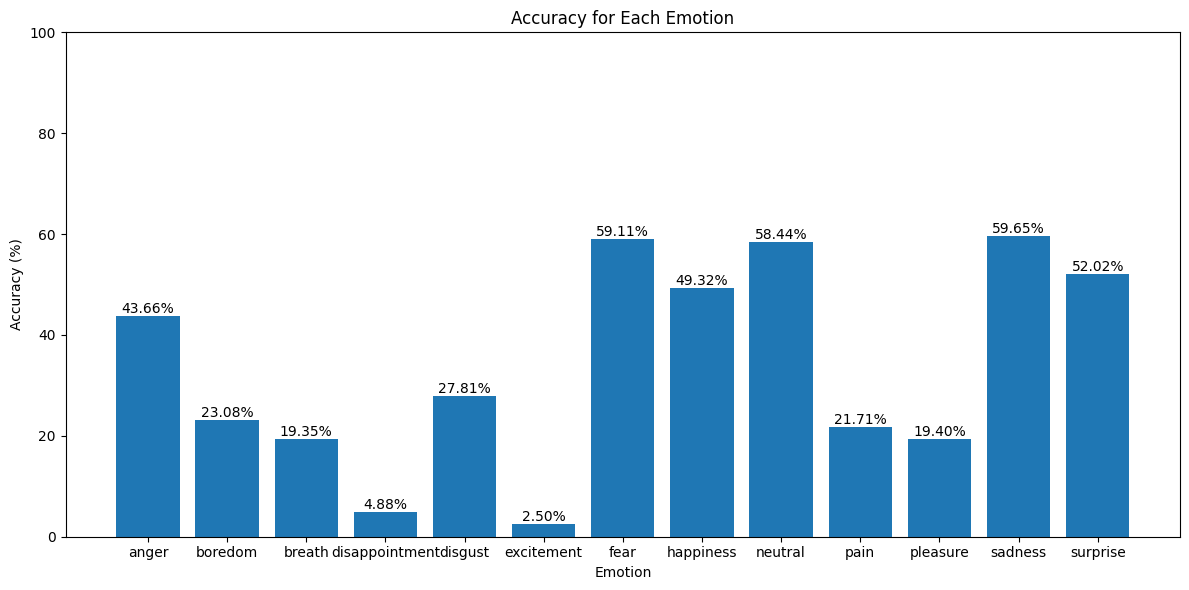

In [31]:
# Calculate accuracy for each emotion
accuracies = []
for i in range(num_classes):
    correct_predictions = confusion_cnn[i, i]
    total_predictions = sum(confusion_cnn[i, :])  # Sum of the row for class i
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracies.append(accuracy)

# Define emotion labels (from label_encoder.classes_)
emotion_labels = label_encoder.classes_

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(emotion_labels, [accuracy * 100 for accuracy in accuracies])  # Convert accuracies to percentages
plt.xlabel('Emotion')
plt.ylabel('Accuracy (%)')  # Change the ylabel to 'Accuracy (%)'
plt.title('Accuracy for Each Emotion')
plt.ylim(0, 100)  # Set the y-axis limit to the range [0, 100]

# Display the accuracy values on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy * 100, f'{accuracy * 100:.2f}%', ha='center', va='bottom')  # Convert accuracy to percentage

# Show the plot
plt.tight_layout()
plt.show()

In [32]:
# Save your trained model
# model_cnn.save('cnns_model')
# model_cnn.save_weights('cnns_model/model_weights.h5')

INFO:tensorflow:Assets written to: cnns_model/assets


INFO:tensorflow:Assets written to: cnns_model/assets


Recurrent Neural Networks (RNNs)

In [33]:
# Define the RNN model
# model_rnn = Sequential([
#     SimpleRNN(128, return_sequences=True, input_shape=(max_length, X_mfcc_features_padded.shape[2])),
#     SimpleRNN(64),
#     Dense(num_classes, activation='softmax')  # Output layer with classes based on your emotion categories
# ])

# # Compile the model
# model_rnn.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy for integer-encoded labels
#               metrics=['accuracy'])

# # Train the model
# model_rnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate the model
# test_loss, test_acc = model_rnn.evaluate(X_test, y_test)
# print(f'Test Accuracy for RNNs :', round(test_acc,3) * 100 ,'%')

# # Make predictions
# y_pred = model_rnn.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Decode encoded labels back to original emotions
# y_test_original = label_encoder.inverse_transform(y_test)
# y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# # Generate a classification report and confusion matrix
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=UserWarning)

#     report_rnn = classification_report(y_test_original, y_pred_original)
# print('Classification Report:\n', report_rnn)

# confusion_rnn = confusion_matrix(y_test_original, y_pred_original)
# print('Confusion Matrix:\n', confusion_rnn)

In [34]:
# Calculate accuracy for each emotion
# accuracies = []
# for i in range(num_classes):
#     correct_predictions = confusion_rnn[i, i]
#     total_predictions = sum(confusion_rnn[i, :])  # Sum of the row for class i
#     accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
#     accuracies.append(accuracy)

# # Define emotion labels (from label_encoder.classes_)
# emotion_labels = label_encoder.classes_

# # Plot the bar chart
# plt.figure(figsize=(12, 6))
# plt.bar(emotion_labels, [accuracy * 100 for accuracy in accuracies])  # Convert accuracies to percentages
# plt.xlabel('Emotion')
# plt.ylabel('Accuracy (%)')  # Change the ylabel to 'Accuracy (%)'
# plt.title('Accuracy for Each Emotion')
# plt.ylim(0, 100)  # Set the y-axis limit to the range [0, 100]

# # Display the accuracy values on top of the bars
# for i, accuracy in enumerate(accuracies):
#     plt.text(i, accuracy * 100, f'{accuracy * 100:.2f}%', ha='center', va='bottom')  # Convert accuracy to percentage

# # Show the plot
# plt.tight_layout()
# plt.show()

CNN-RNN Hybrid model

In [35]:
# Reshape MFCC features for CNN input
# X_train_cnn = X_train[..., np.newaxis]  # Add a channe0l dimension
# X_test_cnn = X_test[..., np.newaxis]

# # Define the CNN-RNN Hybrid model
# model = Sequential([
#     Conv2D(64, (3, 3), activation='relu', input_shape=X_train_cnn[0].shape),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     TimeDistributed(Flatten()),  # Apply Flatten to each time step
#     SimpleRNN(64, return_sequences=True),  # RNN layer after CNN
#     SimpleRNN(64),
#     Dense(64, activation='relu'),
#     Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with classes based on your emotion categories
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy for integer-encoded labels
#               metrics=['accuracy'])

# # Train the model
# model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate the model
# test_loss, test_acc = model.evaluate(X_test_cnn, y_test)
# print(f'Test Accuracy for Hybrid :', round(test_acc,3) * 100 ,'%')

# # Make predictions
# y_pred = model.predict(X_test_cnn)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Decode encoded labels back to original emotions
# y_test_original = label_encoder.inverse_transform(y_test)
# y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# # Generate a classification report and confusion matrix
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=UserWarning)

#     report = classification_report(y_test_original, y_pred_original)
# print('Classification Report:\n', report)

# confusion = confusion_matrix(y_test_original, y_pred_original)
# print('Confusion Matrix:\n', confusion)

In [36]:
# # Load and preprocess the dataset
# X_mfcc_features, y = load_and_preprocess_data()

# # Pad MFCC sequences to have the same length (use the maximum sequence length)
# max_length = max([len(mfcc) for mfcc in X_mfcc_features])
# X_mfcc_features_padded = pad_sequences(X_mfcc_features, maxlen=max_length, padding='post', dtype='float32')

# # Encode emotion labels (convert them to numerical values)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Convert labels to one-hot encoding
# y_onehot = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_mfcc_features_padded, y_onehot, test_size=0.2, random_state=42)

# # Define the neural network model
# model = Sequential([
#     Input(shape=(max_length, X_mfcc_features_padded.shape[2])),  # Define input shape based on your feature dimension
#     LSTM(128, activation='relu', return_sequences=True),
#     Dropout(0.5),
#     LSTM(64, activation='relu'),
#     Dropout(0.5),
#     Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with classes based on your emotion categories
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',  # Use categorical cross-entropy for one-hot encoded labels
#               metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2)

# # Evaluate the model
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print(f'Test accuracy: {test_acc}')

# # Make predictions
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Decode one-hot encoded labels back to original emotions
# y_test_original = label_encoder.inverse_transform(np.argmax(y_test, axis=1))
# y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# # Generate a classification report and confusion matrix
# report = classification_report(y_test_original, y_pred_original)
# print('Classification Report:\n', report)

# confusion = confusion_matrix(y_test_original, y_pred_original)
# print('Confusion Matrix:\n', confusion)